In [1]:
from comp_overrule import learn_srules, learn_s_orules, get_overlap_violations
from comp_overrule_knn import learn_orules as learn_knnrules
from comp_overrule_clr import learn_orules as learn_clrrules

from comp_overrule import plt_cl_lit, plt_sem, get_sem_optim
from utils import rule_str, rules_stats, transcribe, recent_model, covbal_eval, description
from comp_preprocessing import get_data, select_data

from comp_causalmodel import causal_eval, bootstrap_effects, placebo_effects, bootstrap_marginal
from comp_causalmodel import propensity_model, outcome_model
from comp_postivitree import learn_rules

import numpy as np
import pandas as pd

from matplotlib_venn import venn2, venn3
%load_ext autoreload
%autoreload 2

### Preprocessing

In [2]:
folder = '/home/victora/PositivityViolation/'

In [29]:
data = select_data(data_path=folder + 'data/NG_2018_Preprocessed.csv')
data[['treatment', 'outcome']].groupby(['treatment']).mean()

23


,outcome
treatment,
0.0,0.106452
1.0,0.226232


In [6]:
print([description(x) for x in pd.read_csv(DATA_PATH).columns[:-2]])

['Region', 'Type of place of residence', 'Highest educational level', 'Education in single years', 'Sex of household head', 'Literacy', 'Frequency of reading newspaper or magazine', 'Frequency of listening to radio', 'Frequency of watching television', 'Wealth index combined', 'Knowledge of ovulatory cycle', 'Knowledge of any method', 'Current marital status', 'Currently/formerly/never in union', 'Cohabitation duration (grouped)', 'Age at first sex', 'Ideal number of children', 'Exposure', 'Unmet need', "Respondent's current age", 'Heard family planning on radio last few months', 'Heard family planning on TV last few months', 'Heard family planning on newspaper/magazine last few months']


In [30]:
DATA_PATH = folder + 'data/fp_ng-2-select1621335257.csv'
X_df, a, y = get_data(data_path=DATA_PATH, encode=True)

### Causal models

100%|██████████| 1000/1000 [00:03<00:00, 253.90it/s]


(1.1991161616161619, 0.6908074784519711, 2.252762808256027)

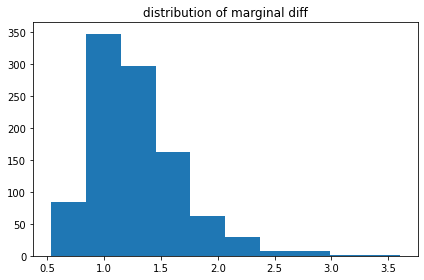

In [7]:
bootstrap_marginal(data_path=DATA_PATH, effect_type='or')

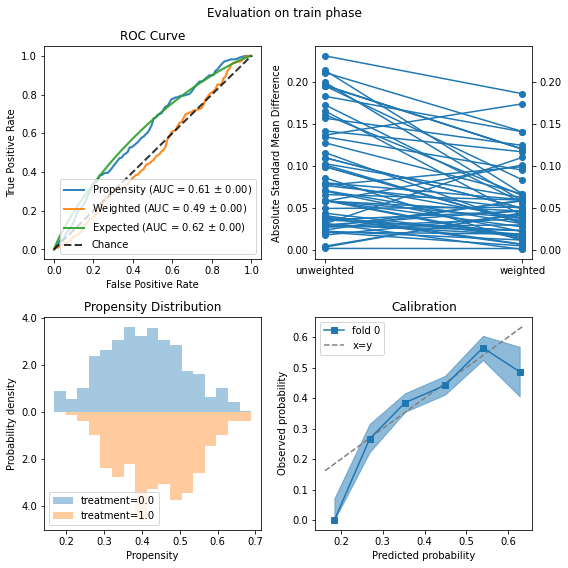

In [31]:
evaluations, X_test, a_test, y_test = propensity_model(data_path=DATA_PATH, encode=True, method='sigmoid')

In [37]:
covbal_eval(evaluations, 3)

array(['Region', 'Cohabitation duration (grouped)'], dtype=object)

100%|██████████| 1000/1000 [00:20<00:00, 48.14it/s]


(2.1029528087406715, 1.3957108557102884, 3.2622944670213596)

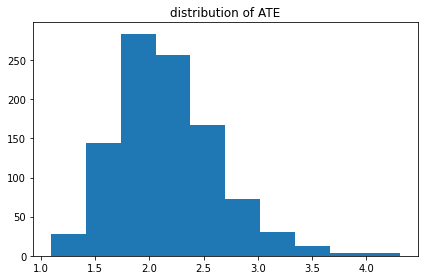

In [33]:
bootstrap_effects(evaluations.models, X_test, a_test, y_test, n_bootstrap=1000, effect_type='or')

In [34]:
bestmodel = evaluations.models.learner.steps[1][1].best_estimator_

100%|██████████| 1000/1000 [01:37<00:00, 10.29it/s]


1.0158193528650423

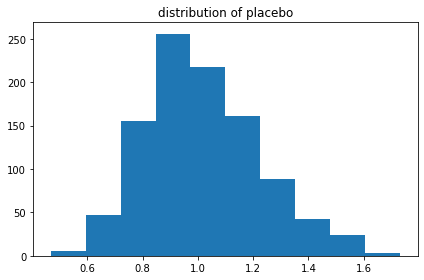

In [35]:
placebo_effects(bestmodel, X_test, a_test, y_test, n_bootstrap=1000)

In [84]:
# evaluations, X_test, y_test, a_test = outcome_model(data_path=DATA_PATH, encode=True)
# evaluations.scores

### Overlap models

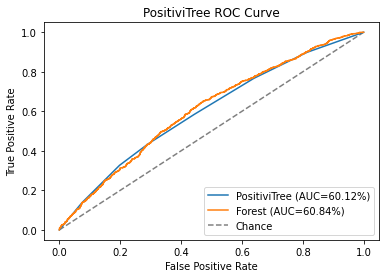

In [42]:
scores, voilating_index, transcript, leaves = learn_rules(data_path=DATA_PATH, var_encoding=folder+ 'data/varencoding-ng.txt', relative=False)

In [43]:
1 - len(voilating_index)/len(X_df)

1.0

In [28]:
transcript

[]

In [169]:
ptree_vindex = voilating_index

knn_vindex = []

clr_vindex = []

support_vindex = []

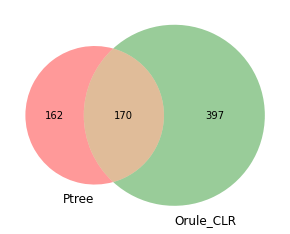

In [170]:
set1 = set(ptree_vindex)
set2 = set(knn_vindex)
set3 = set(clr_vindex)

import matplotlib.pyplot as plt
fig, ax = plt.subplots()
venn2([set1, set3], ('Ptree', 'Orule_CLR'), ax=ax)

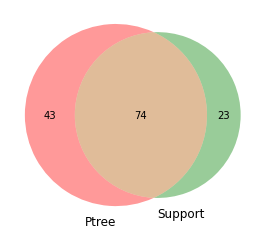

In [33]:
set1 = set(ptree_vindex)
set2 = set(support_vindex)
fig, ax = plt.subplots()
venn2([set1, set2], ('Ptree', 'Support'), ax=ax)

In [33]:
import time
timestamp = str(int(time.time()))
fig.savefig(folder + 'figures/venn3' + timestamp + '.pdf')

In [34]:
overlap_Xdf = X_df.loc[~X_df.index.isin(clr_vindex)]
overlap_adf = a.loc[~X_df.index.isin(clr_vindex)]
overlap_ydf = y.loc[~X_df.index.isin(clr_vindex)]

concat_df = pd.concat((overlap_Xdf, overlap_adf, overlap_ydf), axis=1)

In [35]:
concat_df.to_csv(folder + '/data/fp_select_overlap_clr-et-2.csv', index=False)

In [104]:
import matplotlib.pyplot as plt

In [148]:
o_test_props.values

array([0.61352711, 0.61021695, 0.61114996, ..., 0.6084929 , 0.61149588,
       0.61430583])

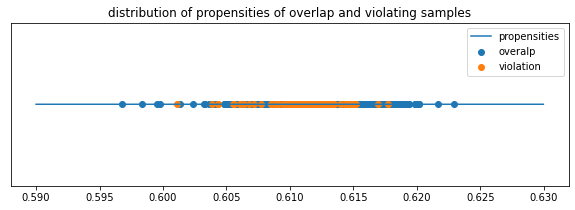

In [168]:
y = [1] * len(o_test_props)
plt.plot(np.arange(0.59, 0.63, 0.040000000000000036/len(o_test_props)), y)
plt.scatter(o_test_props.values, y)

y = [1] * len(v_test_props)
plt.scatter(v_test_props.values, y)


plt.rcParams["figure.figsize"] = (10,3)
plt.yticks([])
plt.legend(['propensities', 'overalp', 'violation'])
plt.title('distribution of propensities of overlap and violating samples')
plt.show()

In [161]:
0.63 - 0.59

0.040000000000000036

In [139]:
v_test = set(voilating_index).intersection(set(a_test.index))
o_test = set(set(a_test.index).difference(voilating_index))

In [ ]:
props = evaluations.models.compute_propensity(X_test, a_test)

o_test_props = props[o_test]
v_test_props = props[v_test]

In [146]:
o_test_props

1       0.613527
4098    0.610217
8       0.611150
4106    0.614256
12      0.611837
          ...   
4080    0.611768
4081    0.611735
4086    0.608493
4087    0.611496
4095    0.614306
Name: 1, Length: 1211, dtype: float64